In [3]:
#!pip3 install --upgrade torch torchvision
!pip3 install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchsummary import summary

In [5]:
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
inputs = feature_extractor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

In [6]:
# Set up device and training hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
latent_dim = 256
epochs = 2
learning_rate = 0.001

print(device)

cuda


In [7]:
num_epochs = 1
batch_size = 512 #Smaller batch - better accuracy
image_height = 224
image_width = 224
num_channels = 3

train_dir = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training"
test_dir = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test"

transforms_data = transforms.Compose([transforms.Resize((image_height, image_width)),
                                        transforms.ToTensor(),
                                     transforms.Normalize([0.6840, 0.5786, 0.5037], [0.3015, 0.3581, 0.3895])])

train_dataset = ImageFolder(train_dir, transform=transforms_data)
test_dataset = ImageFolder(test_dir, transform=transforms_data)
num_classes = len(train_dataset.classes)

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, pin_memory=True)

print('Train Dataset Size: ', len(train_dataset))
print('Test Dataset Size: ', len(test_dataset))

Train Dataset Size:  67692
Test Dataset Size:  22688


In [8]:
class CategoryClass(nn.Module):
    def __init__(self, vit, latent_dim, classes_):
        super(CategoryClass, self).__init__()
        
        self.classes_ = classes_
        
        # Set up model architecture
        self.vit = vit
        self.fc_1 = nn.Linear(768, latent_dim)
        self.fc_out = nn.Linear(latent_dim, self.classes_)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, in_data):
        # Type of output `BaseModelOutputWithPooling`
        vit_outputs = self.vit(in_data)
        
        # Shape of pooler_output: (batch_size, hidden_size)
        pooler_output = vit_outputs.pooler_output
        
        # Pass through the linear layout to predict the class
        # Shape of output: (batch_size, classes_)
        outputs = torch.relu(self.fc_1(pooler_output))
        outputs = self.fc_out(self.dropout(outputs))
        
        return outputs

In [9]:
vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [10]:
# Freeze the layers in vit exclude the pooler layers
for param in vit.parameters():
    param.requires_grad = False

vit.pooler.dense.weight.requires_grad = True
vit.pooler.dense.bias.requires_grad = True

In [11]:
model = CategoryClass(vit,
                      latent_dim,
                      len(train_dataset.classes)).to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [13]:
from datetime import datetime
import math
# Save the training and validating information
training_loss_history =[]
training_accuracy_history = []
validating_loss_history = []
validating_accuracy_history = []

# We only train one epoch
#  Therefore, we save the batch information
batch_loss_history = []
batch_accuracy_history = []

print('Start Training')
print('*'*100)
start_time = datetime.now()
for epoch in range(epochs):
    # Set to the train mode
    model.train()
    
    train_epoch_loss = 0.0
    train_epoch_accuracy = 0.0
    for idx, (images, labels) in enumerate(dataloader_train):
        # Move the data to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Pass through the model
        outputs = model(images)
        
        # Count the loss and update the parameters
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record the training information
        train_epoch_loss += loss.item()
        predict_class = outputs.argmax(dim=-1)
        accuracy = torch.sum(predict_class == labels).item() / labels.shape[0]
        train_epoch_accuracy += accuracy

        # Save the batch information
        batch_loss_history.append(loss.item())
        batch_accuracy_history.append(accuracy)

        # Print batch information
    #print(f" in epoch {epoch + 1}/{epochs}")
        #print(f"Average loss: {loss.item()}")
        #print(f"Average accuracy {accuracy}")
        
    # Set to the eval mode
    model.eval()
    
    val_epoch_loss = 0.0
    val_epoch_accuracy = 0.0
    
    with torch.no_grad():
        for val_images, val_labels in dataloader_test:
            # Move data to the device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Pass through model
            val_outputs = model(val_images)
            
            # Count the loss and accuracy
            val_epoch_loss += criterion(val_outputs, val_labels)
            val_predict_class = val_outputs.argmax(dim=-1)
            val_epoch_accuracy += torch.sum(val_predict_class == val_labels).item() / val_labels.shape[0]
            
    # Save the epoch information
    training_loss_history.append(100*train_epoch_loss / len(dataloader_train))
    training_accuracy_history.append(100*train_epoch_accuracy / len(dataloader_train))
    validating_loss_history.append(100*val_epoch_loss / len(dataloader_test))
    validating_accuracy_history.append(100*val_epoch_accuracy / len(dataloader_test))
    
    print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
          .format(epoch + 1, epochs, training_loss_history[-1], training_accuracy_history[-1], validating_loss_history[-1], validating_accuracy_history[-1]))

    end_time = datetime.now()
    epoch_time = (end_time - start_time).total_seconds()
    print("-"*100)
    print('Epoch Time : ', math.floor(epoch_time // 60), ':', math.floor(epoch_time % 60))
    print("-"*100)
    
print("*** Training Completed ***")

Start Training
****************************************************************************************************
Epoch 1/2, Training Loss: 90.459, Training Accuracy: 82.627, Testing Loss: 13.698, Testing Acc: 96.646
----------------------------------------------------------------------------------------------------
Epoch Time :  30 : 10
----------------------------------------------------------------------------------------------------
Epoch 2/2, Training Loss: 3.609, Training Accuracy: 99.508, Testing Loss: 7.245, Testing Acc: 98.162
----------------------------------------------------------------------------------------------------
Epoch Time :  53 : 40
----------------------------------------------------------------------------------------------------
*** Training Completed ***


In [14]:
# Save the model weight
torch.save(model.state_dict(), "model.pt")

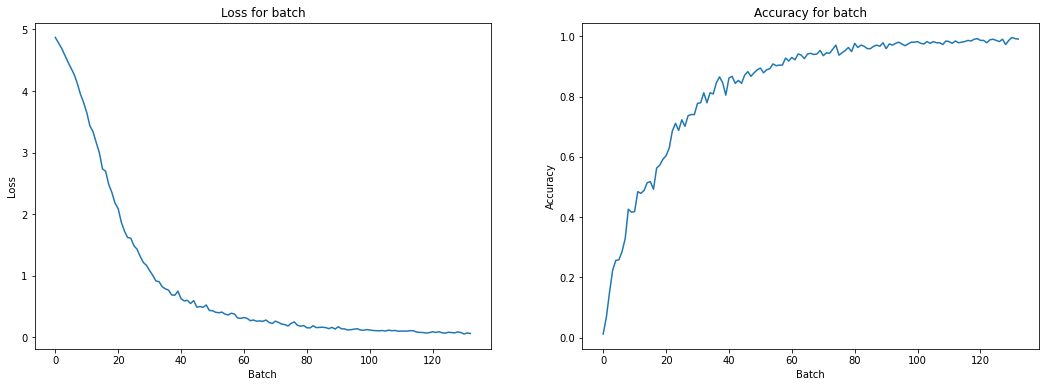

In [14]:
# Plot the loss and accuracy
plt.figure(figsize=(18,6))

# Loss
plt.subplot(1, 2, 1)
plt.title("Loss for batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(batch_loss_history)

# Accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy for batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(batch_accuracy_history)